In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## LOAD DATA

In [2]:
#read in yelp data
yelp_data = pd.read_csv("Oct242018.csv")

In [3]:
#read in health data
health_data = pd.read_csv("DOHMH_New_York_City_Restaurant_Inspection_Results.csv.crdownload")

In [4]:
print(yelp_data.shape)
print(health_data.shape)

(25755, 15)
(354342, 18)


In [5]:
yelp_data.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
yelp_data.head(2)

,DBA,address,ZIPCODE,id,categories,coordinates,hours,image_url,is_closed,photos,price,rating,review_count,transactions
0,#1 Chinese Restaurant,825 W 181ST ST,10033,bMAsaXIDMActYCYCw0HcCQ,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 40.8513816, 'longitude': -73.9394...","[{'open': [{'is_overnight': False, 'start': '1...",https://s3-media1.fl.yelpcdn.com/bphoto/ba6QzI...,False,['https://s3-media1.fl.yelpcdn.com/bphoto/ba6Q...,$,3.5,114,"['pickup', 'delivery']"
1,#1 GARDEN CHINESE RESTAURANT,221 PROSPECT PARK W,11215,4PG9npz7q_LP2H5LfDjWig,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 40.660046, 'longitude': -73.980313}",0,https://s3-media1.fl.yelpcdn.com/bphoto/6FSxbb...,False,['https://s3-media1.fl.yelpcdn.com/bphoto/6FSx...,$,3.5,54,"['delivery', 'pickup']"


In [7]:
health_data.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,41142210,BARBOUNIA,MANHATTAN,250,PARK AVENUE SOUTH,10003.0,2129950242,Mediterranean,04/05/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,13.0,A,04/05/2017,10/17/2018,Cycle Inspection / Re-inspection
1,40548766,JOE'S SHANGHAI RESTAURANT,MANHATTAN,9,PELL STREET,10013.0,2122338888,Chinese,07/02/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,17.0,B,07/02/2018,10/17/2018,Cycle Inspection / Re-inspection


In [8]:
#check out distribution of categories
grades = health_data.groupby("GRADE")["DBA"].count()

In [9]:
grades

GRADE
A                 141453
B                  22721
C                   6683
Not Yet Graded      1675
P                   2101
Z                   4751
Name: DBA, dtype: int64

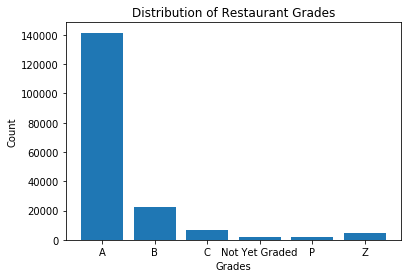

In [10]:
plt.bar(("A","B","C","Not Yet Graded", "P", "Z"), grades)
plt.title("Distribution of Restaurant Grades")
plt.xlabel("Grades")
plt.ylabel("Count");

In [11]:
#need to get unique restaurants to match in both data sets
print(yelp_data["DBA"].nunique())
print(health_data["DBA"].nunique())

20774
21138


In [12]:
#delete missing zipcode data
health_data["ZIPCODE"].fillna(0,inplace=True)
health_data = health_data[health_data["ZIPCODE"]!=0]
health_data["DBA"].nunique()

20793

In [13]:
#delete missing restaurant data
health_data["DBA"].fillna(0,inplace=True)
health_data = health_data[health_data["DBA"]!=0]
health_data.DBA.nunique()

20793

In [14]:
#get address and delete missing address data
health_data["address"]=health_data["BUILDING"] +" " + health_data["STREET"]
health_data["address"].fillna(0,inplace=True)
health_data = health_data[health_data["address"]!=0]
health_data.DBA.nunique()

20774

In [15]:
#merge data to get 1 dataframe
all_data = health_data.merge(yelp_data,how="left", on=["DBA", "ZIPCODE", "address"])

In [16]:
health_data.shape

(348207, 19)

In [17]:
all_data.shape

(348207, 30)

In [18]:
all_data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'address', 'id',
       'categories', 'coordinates', 'hours', 'image_url', 'is_closed',
       'photos', 'price', 'rating', 'review_count', 'transactions'],
      dtype='object')

In [19]:
all_data[all_data["id"]=='0'].shape

(57421, 30)

In [20]:
#check if it's ok to drop restaurants missing yelp info
all_data[all_data["id"]=='0']["SCORE"].mean()

19.63275630530363

In [21]:
all_data[all_data["id"]=='0'].groupby("GRADE")["DBA"].count()

GRADE
A                 22882
B                  3759
C                  1082
Not Yet Graded      631
P                   369
Z                   827
Name: DBA, dtype: int64

In [22]:
all_data[all_data["id"]!='0']["SCORE"].mean()

19.43839874365859

In [23]:
all_data[all_data["id"]!='0'].groupby("GRADE")["DBA"].count()

GRADE
A                 116099
B                  18661
C                   5514
Not Yet Graded      1034
P                   1708
Z                   3827
Name: DBA, dtype: int64

## Get Additional Features

In [24]:
all_data["INSPECTION_DATE_FORMAT"] = pd.to_datetime(all_data["INSPECTION DATE"])

In [25]:
all_data["INSPECTION_MONTH"] = all_data["INSPECTION_DATE_FORMAT"].apply(lambda x: x.month)

In [26]:
all_data["INSPECTION_YEAR"] = all_data["INSPECTION_DATE_FORMAT"].apply(lambda x: x.year)

In [27]:
scores_by_month = all_data.groupby(["INSPECTION_YEAR","INSPECTION_MONTH"])["SCORE"].mean().reset_index()

In [28]:
scores_by_month2 = all_data.groupby(["INSPECTION_YEAR","INSPECTION_MONTH"])["SCORE"].median().reset_index()

In [29]:
year_groups = all_data.groupby(["INSPECTION_YEAR","GRADE"])["DBA"].count().reset_index()

In [30]:
s_15 = scores_by_month[scores_by_month["INSPECTION_YEAR"]==2015]
s_16 = scores_by_month[scores_by_month["INSPECTION_YEAR"]==2016]
s_17 = scores_by_month[scores_by_month["INSPECTION_YEAR"]==2017]
s_18 = scores_by_month[scores_by_month["INSPECTION_YEAR"]==2018]

s_15_2 = scores_by_month2[scores_by_month2["INSPECTION_YEAR"]==2015]
s_16_2 = scores_by_month2[scores_by_month2["INSPECTION_YEAR"]==2016]
s_17_2 = scores_by_month2[scores_by_month2["INSPECTION_YEAR"]==2017]
s_18_2 = scores_by_month2[scores_by_month2["INSPECTION_YEAR"]==2018]

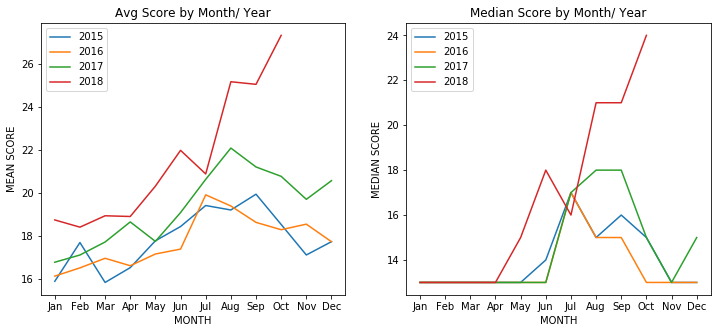

In [31]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(s_15["INSPECTION_MONTH"],s_15["SCORE"])
plt.plot(s_16["INSPECTION_MONTH"],s_16["SCORE"])
plt.plot(s_17["INSPECTION_MONTH"],s_17["SCORE"])
plt.plot(s_18["INSPECTION_MONTH"],s_18["SCORE"])
plt.title("Avg Score by Month/ Year")
plt.xlabel("MONTH")
plt.ylabel("MEAN SCORE")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(["2015", "2016", "2017", "2018"])

plt.subplot(1,2,2)
plt.plot(s_15_2["INSPECTION_MONTH"],s_15_2["SCORE"])
plt.plot(s_16_2["INSPECTION_MONTH"],s_16_2["SCORE"])
plt.plot(s_17_2["INSPECTION_MONTH"],s_17_2["SCORE"])
plt.plot(s_18_2["INSPECTION_MONTH"],s_18_2["SCORE"])
plt.title("Median Score by Month/ Year")
plt.xlabel("MONTH")
plt.ylabel("MEDIAN SCORE")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(["2015", "2016", "2017", "2018"]);

In [32]:
boros = all_data.groupby("BORO")["DBA"].count().reset_index().sort_values(by="DBA",ascending=False).head()

In [33]:
boros

,BORO,DBA
2,MANHATTAN,137050
1,BROOKLYN,89525
4,QUEENS,78424
0,BRONX,31028
5,STATEN ISLAND,12166


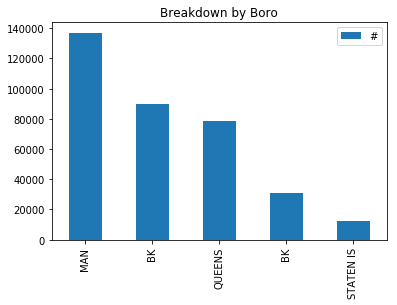

In [34]:
boros.plot(kind="bar")
plt.xticks([0,1,2,3,4],["MAN", "BK", "QUEENS", "BK", "STATEN IS"])
plt.title("Breakdown by Boro")
plt.legend("# Grades");

In [35]:
prices = all_data.groupby("price")["DBA"].count().head(4)

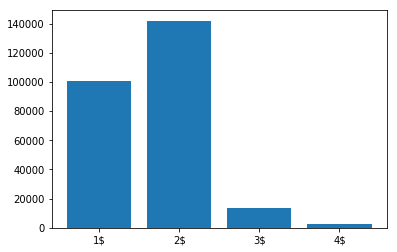

In [36]:
plt.bar(["1$","2$","3$","4$"],prices);

In [37]:
def get_numeric_price(x):
    if x=='0':
        return 0
    else:
        return len(x)

In [38]:
all_data["PRICE_NUM"] = all_data["price"].apply(lambda x: get_numeric_price(x))

### Separate out only data w valid grades

In [39]:
letter_data = all_data[all_data["GRADE"].isin(["A","B","C"])]

In [40]:
letter_data.shape

(167997, 34)

In [41]:
letter_data["GRADE DATE"] = pd.to_datetime(letter_data["GRADE DATE"])

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
letter_data["GRADE MONTH"] = letter_data["GRADE DATE"].apply(lambda x: x.month)

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
letter_data["GRADE YEAR"] = letter_data["GRADE DATE"].apply(lambda x: x.year)

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
#filter out irrelevant inspection types
letter_data["INSPECTION TYPE"].unique()

array(['Cycle Inspection / Re-inspection',
       'Cycle Inspection / Initial Inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Cycle Inspection / Reopening Inspection',
       'Pre-permit (Operational) / Reopening Inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Pre-permit (Non-operational) / Initial Inspection'], dtype=object)

In [45]:
inspect_types = ['Cycle Inspection / Re-inspection',
       'Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Reopening Inspection']

In [46]:
letter_data = letter_data[letter_data["INSPECTION TYPE"].isin(inspect_types)]

In [47]:
letter_data.shape

(151153, 36)

In [48]:
letter_data.sort_values(by=["CAMIS", "GRADE DATE"],inplace=True)

In [49]:
#filter out multiple violations in same inspection
small_letter_data = letter_data.drop_duplicates(["CAMIS","INSPECTION DATE"])

In [50]:
num_A = small_letter_data[small_letter_data["GRADE"]=="A"].shape[0]

In [51]:
num_B = small_letter_data[small_letter_data["GRADE"]=="B"].shape[0]

In [52]:
num_C = small_letter_data[small_letter_data["GRADE"]=="C"].shape[0]

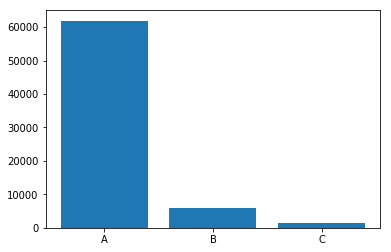

In [53]:
plt.bar(["A","B","C"],[num_A,num_B,num_C]);

In [54]:
small_letter_data["GRADE YEAR"].unique()

array([2016, 2017, 2018, 2015, 2014, 2013, 2012])

In [63]:
small_letter_data[(small_letter_data["GRADE YEAR"]==2015) & (small_letter_data["INSPECTION_MONTH"]<7)]["CUISINE DESCRIPTION"].value_counts()

American                                                            964
Chinese                                                             271
Pizza                                                               162
Italian                                                             152
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    142
CafÃ©/Coffee/Tea                                                    137
Japanese                                                            125
Mexican                                                             116
Bakery                                                               93
Caribbean                                                            91
Pizza/Italian                                                        80
Donuts                                                               79
Hamburgers                                                           66
Spanish                                                         

In [56]:
small_letter_data[small_letter_data["GRADE YEAR"]==2015].shape

(10291, 36)

In [64]:
#get data for full years of inspection
small_letter_data = small_letter_data[small_letter_data["GRADE YEAR"]>2014]

In [65]:
def get_lat(x):
    if x==0:
        return 0
    else:
        return x["latitude"]
def get_long(x):
    if x==0:
        return 0
    else:
        return x["longitude"]

In [66]:
small_letter_data.coordinates.iloc[1]

"{'latitude': 40.84839, 'longitude': -73.85601}"

In [67]:
import ast
ast.literal_eval("{'latitude': 40.84839, 'longitude': -73.85601}")["latitude"]

40.84839

In [68]:
small_letter_data["coordinates"] = small_letter_data["coordinates"].apply(lambda x: ast.literal_eval(x))
small_letter_data["LAT"] = small_letter_data["coordinates"].apply(lambda x: get_lat(x))

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
small_letter_data["LONG"] = small_letter_data["coordinates"].apply(lambda x: get_long(x))

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
small_letter_data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'address', 'id',
       'categories', 'coordinates', 'hours', 'image_url', 'is_closed',
       'photos', 'price', 'rating', 'review_count', 'transactions',
       'INSPECTION_DATE_FORMAT', 'INSPECTION_MONTH', 'INSPECTION_YEAR',
       'PRICE_NUM', 'GRADE MONTH', 'GRADE YEAR', 'LAT', 'LONG'],
      dtype='object')

In [71]:
small_letter_data[small_letter_data["id"]=='0']["CAMIS"].nunique()

3853

In [72]:
small_letter_data2 = small_letter_data[small_letter_data["id"]!='0']

In [73]:
small_letter_data2.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'address', 'id',
       'categories', 'coordinates', 'hours', 'image_url', 'is_closed',
       'photos', 'price', 'rating', 'review_count', 'transactions',
       'INSPECTION_DATE_FORMAT', 'INSPECTION_MONTH', 'INSPECTION_YEAR',
       'PRICE_NUM', 'GRADE MONTH', 'GRADE YEAR', 'LAT', 'LONG'],
      dtype='object')

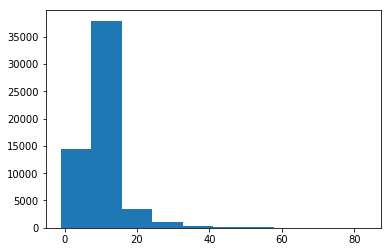

In [74]:
plt.hist(small_letter_data2["SCORE"]);

## Get Dummy Variables

In [68]:
cuisine_dummies = pd.get_dummies(small_letter_data2["CUISINE DESCRIPTION"]).astype(int)

In [69]:
df_dum = pd.concat([small_letter_data2, cuisine_dummies],axis=1)

In [70]:
df_dum.shape

(57456, 123)

In [75]:
boro_dummies = pd.get_dummies(small_letter_data2["BORO"]).astype(int)

In [76]:
df_dum = pd.concat([small_letter_data2, boro_dummies],axis=1)

In [77]:
cols = ["ZIPCODE", "INCOME_GROUP", "SIZE"]
income_df = pd.read_excel("income_data.xlsx", names = cols)

In [78]:
income_df.dropna(how="all",inplace=True)

In [79]:
zips = [    0., 10001., 10002., 10003., 10004., 10005., 10006., 10007.,
       10009., 10010., 10011., 10012., 10013., 10014., 10016., 10017.,
       10018., 10019., 10021.,   10022., 10023., 10024., 10025.,
       10026., 10027., 10028., 10029., 10030., 10031., 10032., 10033.,
       10034., 10035., 10036., 10037., 10038., 10039., 10040., 10044.,
       10065., 10069., 10075., 10128., 10162., 10280., 10282., 10301.,
       10302., 10303., 10304., 10305., 10306., 10307., 10308., 10309.,
       10310., 10312., 10314., 10451., 10452., 10453., 10454., 10455.,
       10456., 10457., 10458., 10459., 10460., 10461., 10462., 10463.,
       10464., 10465., 10466., 10467., 10468., 10469., 10470., 10471.,
       10472., 10473., 10474., 10475., 10501., 10502., 10504., 10505.,
       10506., 10507., 10509., 10510., 10511., 10512., 10514., 10516.,
       10518., 10520., 10522., 10523., 10524., 10526., 10527., 10528.,
       10530., 10532., 10533., 10535., 10536., 10537., 10538., 10541.,
       10543., 10546., 10547., 10548., 10549., 10550., 10552., 10553.,
       10560., 10562., 10566., 10567., 10570., 10573., 10576., 10577.,
       10578., 10579., 10580., 10583., 10588., 10589., 10590., 10591.,
       10594., 10595., 10597., 10598., 10601., 10603., 10604., 10605.,
       10606., 10607., 10701., 10703., 10704., 10705., 10706., 10707.,
       10708., 10709., 10710., 10801., 10803., 10804., 10805., 10901.,
       10913., 10916., 10917., 10918., 10919., 10920., 10921., 10923.,
       10924., 10925., 10926., 10927., 10928., 10930., 10931., 10940.,
       10941., 10950., 10952., 10954., 10956., 10958., 10960., 10962.,
       10963., 10964., 10965., 10968., 10969., 10970., 10973., 10974.,
       10975., 10976., 10977., 10980., 10983., 10984., 10985., 10986.,
       10987., 10989., 10990., 10992., 10993., 10994., 10996., 10998.,
       11001., 11003., 11004., 11005., 11010., 11020., 11021., 11023.,
       11024., 11030., 11040., 11050., 11096., 11101., 11102., 11103.,
       11104., 11105., 11106., 11109., 11201., 11203., 11204., 11205.,
       11206., 11207., 11208., 11209., 11210., 11211., 11212., 11213.,
       11214., 11215., 11216., 11217., 11218., 11219., 11220., 11221.,
       11222., 11223., 11224., 11225., 11226., 11228., 11229., 11230.,
       11231., 11232., 11233., 11234., 11235., 11236., 11237., 11238.,
       11239., 11354., 11355., 11356., 11357., 11358., 11360., 11361.,
       11362., 11363., 11364., 11365., 11366., 11367., 11368., 11369.,
       11370., 11372., 11373., 11374., 11375., 11377., 11378., 11379.,
       11385., 11411., 11412., 11413., 11414., 11415., 11416., 11417.,
       11418., 11419., 11420., 11421., 11422., 11423., 11426., 11427.,
       11428., 11429., 11430., 11432., 11433., 11434., 11435., 11436.,
       11501., 11507., 11509., 11510., 11514., 11516., 11518., 11520.,
       11530., 11542., 11545., 11548., 11550., 11552., 11553., 11554.,
       11557., 11558., 11559., 11560., 11561., 11563., 11565., 11566.,
       11568., 11570., 11572., 11575., 11576., 11577., 11579., 11580.,
       11581., 11590., 11596., 11598., 11691., 11692., 11693., 11694.,
       11697.]

In [80]:
new_df = pd.DataFrame(columns = ["ZIPCODE", "<$25K", "$25K-$50K", "$50K-$75K", "$75K-$100K", "$100K-$200K", "$200K+"])

In [81]:
new_list = []
for i in zips:
    x = income_df[(income_df["ZIPCODE"]==i) & (income_df["INCOME_GROUP"]=="$1 under $25,000")]["SIZE"].item()
    new_list.append(x)

In [82]:
new_df.columns

Index(['ZIPCODE', '<$25K', '$25K-$50K', '$50K-$75K', '$75K-$100K',
       '$100K-$200K', '$200K+'],
      dtype='object')

In [83]:
new_list2 = []
for i in zips:
    x = new_df[new_df["ZIPCODE"]==i]["$25K-$50K"] = income_df[(income_df["ZIPCODE"]==i) & (income_df["INCOME_GROUP"]=="$25,000 under $50,000")]["SIZE"].item()
    new_list2.append(x)

In [84]:
new_list3 = []
for i in zips:
    x = income_df[(income_df["ZIPCODE"]==i) & (income_df["INCOME_GROUP"]=="$50,000 under $75,000")]["SIZE"].item()
    new_list3.append(x)

In [85]:
new_list4 = []
for i in zips:
    x = income_df[(income_df["ZIPCODE"]==i) & (income_df["INCOME_GROUP"]=="$75,000 under $100,000")]["SIZE"].item()
    new_list4.append(x)

In [86]:
new_list5 = []
for i in zips:
    x = income_df[(income_df["ZIPCODE"]==i) & (income_df["INCOME_GROUP"]=="$100,000 under $200,000")]["SIZE"].item()
    new_list5.append(x)

In [87]:
new_list6 = []
for i in zips:
    x = income_df[(income_df["ZIPCODE"]==i) & (income_df["INCOME_GROUP"]=="$200,000 or more")]["SIZE"].item()
    new_list6.append(x)

In [88]:
new_df.columns

Index(['ZIPCODE', '<$25K', '$25K-$50K', '$50K-$75K', '$75K-$100K',
       '$100K-$200K', '$200K+'],
      dtype='object')

In [89]:
new_df["ZIPCODE"] = zips

In [90]:
new_df["<$25K"] = new_list

In [91]:
new_df["$25K-$50K"] = new_list2

In [92]:
new_df["$50K-$75K"] = new_list3

In [93]:
new_df["$75K-$100K"] = new_list4

In [94]:
new_df["$100K-$200K"] = new_list5

In [95]:
new_df["$200K+"] = new_list6

In [96]:
new_df["TOTAL"] = new_df["<$25K"] + new_df["$25K-$50K"] + new_df["$50K-$75K"]+new_df["$75K-$100K"]+new_df["$100K-$200K"] + new_df["$200K+"]

In [97]:
new_df["Perc_$25K"] = new_df["<$25K"]/new_df["TOTAL"]
new_df["Perc_$50K"] = new_df["$25K-$50K"]/new_df["TOTAL"]
new_df["Perc_$75K"] = new_df["$50K-$75K"]/new_df["TOTAL"]
new_df["Perc_$100K"] = new_df["$75K-$100K"]/new_df["TOTAL"]
new_df["Perc_$200K"] = new_df["$100K-$200K"]/new_df["TOTAL"]
new_df["Perc_+$200K"] = new_df["$200K+"]/new_df["TOTAL"]

In [98]:
fin_df  = df_dum.merge(new_df,how="left", on=["ZIPCODE"])

## More Features

In [99]:
fin_df[fin_df["Missing"]==1]["Brooklyn"]=1

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [100]:
fin_df.drop("Missing", axis=1, inplace=True)

### Get Chain Restaurants

In [101]:
chains = ["MCDONALDS","MCDONALD'S ","POPEYES LOUISIANA KITCHEN","CROWN FRIED CHICKEN","GOLDEN KRUST CARIBBEAN BAKERY & GRILL",
"SUBWAY","PAPA JOHN'S","JUST SALAD","STARBUCKS COFFEE","VIVI BUBBLE TEA","JUICE GENERATION","THINK COFFEE","GREGORY'S COFFEE",
"STARBUCKS","LENWICH","BARNES & NOBLE CAFE","KUNG FU TEA","TEXAS CHICKEN & BURGERS",
"BURGER KING",
"WENDY'S",
"TACO BELL",
"DUNKIN DONUTS","DUNKIN' DONUTS","JAMBA JUICE",
"PIZZA HUT",
"KFC",
"CHICK-FIL-A","DALLAS BBQ","CHECKER'S",
"OLIVE GARDEN","TACO BELL AND PIZZA HUT",
"DOMINO'S",
"PANERA BREAD",
"ARBY'S", "DUNKIN' DONUTS, HUDSON NEWS","DUNKIN' DONUTS, BASKIN ROBBINS, HUDSON NEWS",
"RED LOBSTER","HARD ROCK CAFE", "POTBELLY SANDWICH WORKS","KFC, TACO BELL, SOUTH PHILLY STEAKS & FRIES",
"IHOP",
"DENNY'S","AU BON PAIN, ANDALE MEXICAN GRILL",
"OUTBACK STEAKHOUSE","FIVE GUYS FAMOUS BURGERS AND FRIES","AUNTIE ANNE'S PRETZELS",
"CHIPOTLE MEXICAN GRILL","TACO BELL PIZZA HUT","MAOZ Falafel & Grill","CARVEL ICE CREAM","MAGNOLIA BAKERY",
"PAPA JOHN'S PIZZA",
"BUFFALO WILD WINGS","PRET A MANGER","LITTLE CAESARS","HALE & HEARTY SOUP","INSOMNIA COOKIES","COLD STONE CREAMERY",
"T.G.I. FRIDAY'S",
"POPEYES","APPLEBEE'S","COSI","DIG INN SEASONAL MARKET","ARGOTEA","SUBWAY/NATHAN'S FAMOUS",
"THE CHEESECAKE FACTORY","DIG INN","BAREBURGER","PARIS BAGUETTE","MAISON KAYSER","FRESH & CO","NATHAN'S FAMOUS",
"PANDA EXPRESS",
"LITTLE CAESARS PIZZA","DUNKIN' DONUTS, BASKIN ROBBINS",
"FIVE GUYS BURGERS AND FRIES","SHAKE SHACK", "SWEETGREEN", "HOOTERS", "BOSTON MARKET","KRISPY KREME",
         "QDOBA MEXICAN GRILL", "WHITE CASTLE", "BASKIN ROBBINS", "JAMBA JUICE","CHECKERS", "SBARO",
         "CHUCK E. CHEESE'S", "AU BON PAIN", "LE PAIN QUOTIDIEN", "RED MANGO","16 HANDLES", "PINKBERRY", 
         ]

In [102]:
chains.sort()

In [103]:
fin_df["CHAIN"] = fin_df["DBA"].isin(chains)

### Get Opening & Closing Hours

In [104]:
def get_hours(x):
    try:
        y = ast.literal_eval(x)
        start = y[0]["open"][0]["start"]
        return int(start)
    except:
        return 0

In [105]:
def get_hours2(x):
    try:
        y = ast.literal_eval(x)
        end = y[0]["open"][0]["end"]
        return int(end)
    except:
        0

In [106]:
def DAY(x):
    if x<1800:
        return 1
    else:
        return 0

In [107]:
fin_df["OPEN"] = fin_df["hours"].apply(lambda x: get_hours(x))

In [108]:
fin_df["CLOSE"] = fin_df["hours"].apply(lambda x: get_hours2(x))

In [109]:
fin_df["DAY"] = fin_df.CLOSE.apply(lambda x: DAY(x))

### Compress Cuisine to Smaller # Categories

In [110]:
def compress_cuisine(x):
    if x in ["African","Egyptian","Ethiopian"]:
        return "African"
    elif x in ["American", "Armenian", "Californian","Scandinavian", "Pancakes/Waffles"]:
        return "American"
    elif x in ["Bakery", "Donuts"]:
        return "Bakery"
    elif x in ["CafÃ©/Coffee/Tea", "Bottled beverages, including water, sodas, juices, etc."]:
        return "Cafe"
    elif x in['Chinese','Chinese/Japanese','Chinese/Cuban']:
        return "Chinese"
    elif x in['Creole','Creole/Cajun','Caribbean','Cajun']:
        return "Cajun"
    elif x in['English','Australian','Irish',]:
        return "English"
    elif x in['German','Polish','Eastern European','Czech']:
        return "Eastern_Euro"
    elif x in['Hotdogs','Hotdogs/Pretzels','Nuts/Confectionary']:
        return "Hotdog"
    elif x in['Indian','Pakistani']:
        return "Indian"
    elif x in['Juice, Smoothies, Fruit Salads','Fruits/Vegetables']:
        return "Smoothie"
    elif x in ['Latin (Cuban, Dominican, Puerto Rican, South & Central American)','Chilean','Peruvian','Brazilian']:
        return "Latin"
    elif x in['Mediterranean','Greek']:
        return "Greek"
    elif x in['Mexican','Tex-Mex']:
        return "Mexican"
    elif x in['Middle Eastern','Moroccan','Turkish','Iranian','Afghan']:
        return "Midd_East"
    elif x in['Not Listed/Not Applicable','Other']:
        return "Other"
    elif x in['Pizza','Pizza/Italian']:
        return "Pizza"
    elif x in['Polynesian','Hawaiian']:
        return "Hawaiian"
    elif x in[ 'Sandwiches','Sandwiches/Salads/Mixed Buffet','Soups','Soups & Sandwiches','Salads']:
        return "Sandwich"
    elif x in['Soul Food','Southwestern']:
        return "Southern"
    elif x in['Spanish','Basque','Tapas','Portuguese']:
        return "Spanish"
    elif x in['Vietnamese/Cambodian/Malaysia','Indonesian']:
        return "Viet_Indo"
    else:
        return x

In [111]:
fin_df["CUISINE_COMP"] = fin_df["CUISINE DESCRIPTION"].apply(lambda x: compress_cuisine(x))

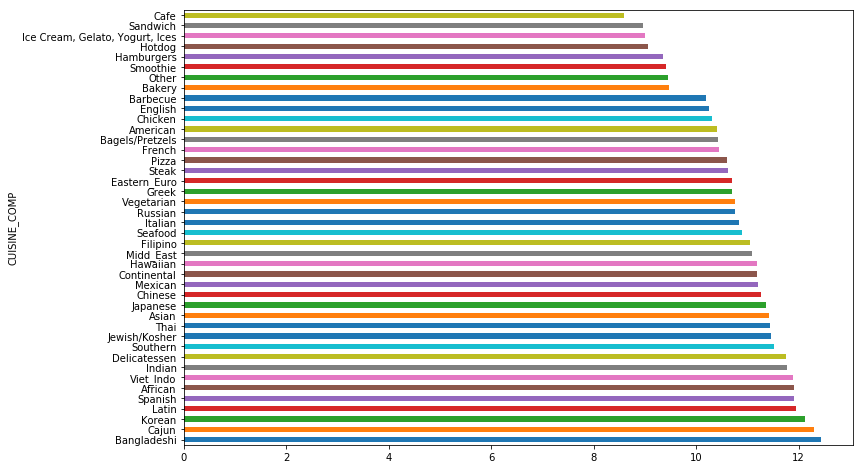

In [112]:
plt.figure(figsize=(12,8))
fin_df.groupby("CUISINE_COMP").SCORE.mean().sort_values(ascending=False).plot(kind="barh")

In [116]:
cuisine_dummies = pd.get_dummies(fin_df["CUISINE_COMP"]).astype(int)

fin_df = pd.concat([fin_df, cuisine_dummies],axis=1)

fin_df.shape

(57456, 103)

In [117]:
list(fin_df.columns)

['CAMIS',
 'DBA',
 'BORO',
 'BUILDING',
 'STREET',
 'ZIPCODE',
 'PHONE',
 'CUISINE DESCRIPTION',
 'INSPECTION DATE',
 'ACTION',
 'VIOLATION CODE',
 'VIOLATION DESCRIPTION',
 'CRITICAL FLAG',
 'SCORE',
 'GRADE',
 'GRADE DATE',
 'RECORD DATE',
 'INSPECTION TYPE',
 'address',
 'id',
 'categories',
 'coordinates',
 'hours',
 'image_url',
 'is_closed',
 'photos',
 'price',
 'rating',
 'review_count',
 'transactions',
 'INSPECTION_DATE_FORMAT',
 'INSPECTION_MONTH',
 'INSPECTION_YEAR',
 'PRICE_NUM',
 'GRADE MONTH',
 'GRADE YEAR',
 'LAT',
 'LONG',
 'BRONX',
 'BROOKLYN',
 'MANHATTAN',
 'QUEENS',
 'STATEN ISLAND',
 '<$25K',
 '$25K-$50K',
 '$50K-$75K',
 '$75K-$100K',
 '$100K-$200K',
 '$200K+',
 'TOTAL',
 'Perc_$25K',
 'Perc_$50K',
 'Perc_$75K',
 'Perc_$100K',
 'Perc_$200K',
 'Perc_+$200K',
 'CHAIN',
 'OPEN',
 'CLOSE',
 'DAY',
 'CUISINE_COMP',
 'African',
 'American',
 'Asian',
 'Bagels/Pretzels',
 'Bakery',
 'Bangladeshi',
 'Barbecue',
 'Cafe',
 'Cajun',
 'Chicken',
 'Chinese',
 'Continental',
 '

In [113]:
cuisine_freq = fin_df["CUISINE_COMP"].value_counts().reset_index()

In [114]:
cuisine_freq.set_index("index", inplace=True)

In [115]:
fin_df["CUISINE_FREQ"] = fin_df["CUISINE_COMP"].apply(lambda x: cuisine_freq.loc[x])

### Get Binary Grades (A or Not A (B or C)

In [116]:
def get_score_bin(x):
    if x=="A":
        return 0
    else:
        return 1

In [117]:
fin_df["GRADE_BIN"] = fin_df["GRADE"].apply(lambda x: get_score_bin(x))

In [118]:
fin_df[fin_df["Perc_+$200K"]>.25].GRADE.value_counts()

A    6794
B     615
C     143
Name: GRADE, dtype: int64

In [119]:
fin_df[fin_df["Perc_$25K"]>.5].GRADE.value_counts()

A    6601
B     832
C     206
Name: GRADE, dtype: int64

In [120]:
fin_df["RICH"] = fin_df["Perc_+$200K"]>.25

In [121]:
fin_df["POOR"] = fin_df["Perc_$25K"]>.5

### Add Column for Non-american/european restaurant

In [122]:
bad_score = ["Bangladeshi",
"Cajun",
"Korean",
"Latin",
"Spanish",
"African",
"Viet_Indo",
"Indian",
"Delicatessen",
"Southern",
"Jewish/Kosher",
"Thai",
"Asian",
"Japanese",
"Chinese",
"Mexican"]

In [123]:
fin_df["BAD_SCORE"] = fin_df["CUISINE_COMP"].isin(bad_score)

### Add Rat Data

In [124]:
import pandas as pd

In [125]:
rats = pd.read_csv("rats.csv")

In [126]:
rats.drop("Unnamed: 0", axis=1, inplace=True)

In [127]:
rats.columns=["ZIPCODE", "RAT_INSPEC"]

In [128]:
fin_df2 = fin_df.merge(rats,how="left", on=["ZIPCODE"])

In [129]:
fin_df2[fin_df2["GRADE_BIN"]==1].RAT_INSPEC.median()

8622.0

In [130]:
fin_df2[fin_df2["GRADE_BIN"]==0].RAT_INSPEC.median()

8344.0

In [131]:
fin_df2["RAT_INSPEC"].median()

8344.0

### Add Cuisine %

In [152]:
first_2015 = fin_df2[(fin_df["INSPECTION_YEAR"]==2015)]

In [153]:
a = first_2015[first_2015["GRADE_BIN"]==1]["CUISINE_COMP"].value_counts().reset_index()

In [154]:
b = fin_df2["CUISINE_COMP"].value_counts().reset_index()

In [155]:
c = a.merge(b, how="left", on="index")

In [169]:
c["Perc_Total"] = c["CUISINE_COMP_x"]/c["CUISINE_COMP_y"]
c.columns = ["CUISINE_COMP", "CUISINE_COMP_x", "CUISINE_COMP_y", "Perc_Total", "INSPECTION_YEAR"]

c["INSPECTION_YEAR"] = 2016
c.sort_values(by="Perc_Total", ascending=False)


,CUISINE_COMP,CUISINE_COMP_x,CUISINE_COMP_y,Perc_Total,INSPECTION_YEAR
31,Hotdog,3,75,0.040000,2016
24,African,8,216,0.037037,2016
12,Korean,19,533,0.035647,2016
33,Filipino,3,86,0.034884,2016
22,Viet_Indo,9,260,0.034615,2016
3,Latin,80,2355,0.033970,2016
30,Southern,4,129,0.031008,2016
6,Japanese,48,1949,0.024628,2016
11,Delicatessen,19,805,0.023602,2016
25,Eastern_Euro,8,339,0.023599,2016


In [172]:
first_2016 = fin_df2[(fin_df["INSPECTION_YEAR"]<2017)]

a1 = first_2016[first_2016["GRADE_BIN"]==1]["CUISINE_COMP"].value_counts().reset_index()

b1 = fin_df2["CUISINE_COMP"].value_counts().reset_index()

c1 = a1.merge(b1, how="left", on="index")

c1["Perc_Total"] = c1["CUISINE_COMP_x"]/c1["CUISINE_COMP_y"]
c1["INSPECTION_YEAR"] = 2017
c1.columns = ["CUISINE_COMP", "CUISINE_COMP_x", "CUISINE_COMP_y", "Perc_Total", "INSPECTION_YEAR"]


c1.sort_values(by="Perc_Total", ascending=False)

,CUISINE_COMP,CUISINE_COMP_x,CUISINE_COMP_y,Perc_Total,INSPECTION_YEAR
29,Southern,13,129,0.100775,2017
34,Filipino,8,86,0.093023,2017
3,Latin,209,2355,0.088747,2017
33,Bangladeshi,9,111,0.081081,2017
25,African,17,216,0.078704,2017
14,Korean,39,533,0.073171,2017
8,Cajun,109,1548,0.070413,2017
26,Viet_Indo,17,260,0.065385,2017
9,Spanish,86,1324,0.064955,2017
11,Delicatessen,52,805,0.064596,2017


In [167]:
first_2017 = fin_df2[(fin_df["INSPECTION_YEAR"]<2018)]

a2 = first_2016[first_2016["GRADE_BIN"]==1]["CUISINE_COMP"].value_counts().reset_index()

b2 = fin_df2["CUISINE_COMP"].value_counts().reset_index()

c2 = a1.merge(b2, how="left", on="index")

c2["Perc_Total"] = c2["CUISINE_COMP_x"]/c1["CUISINE_COMP_y"]
c2.columns = ["CUISINE_COMP", "CUISINE_COMP_x", "CUISINE_COMP_y", "Perc_Total"]

c2["INSPECTION_YEAR"] = 2018
c2.sort_values(by="Perc_Total", ascending=False)

,CUISINE_COMP,CUISINE_COMP_x,CUISINE_COMP_y,Perc_Total,INSPECTION_YEAR
29,Southern,13,129,0.100775,2018
34,Filipino,8,86,0.093023,2018
3,Latin,209,2355,0.088747,2018
33,Bangladeshi,9,111,0.081081,2018
25,African,17,216,0.078704,2018
14,Korean,39,533,0.073171,2018
8,Cajun,109,1548,0.070413,2018
26,Viet_Indo,17,260,0.065385,2018
9,Spanish,86,1324,0.064955,2018
11,Delicatessen,52,805,0.064596,2018


In [195]:
c_fin = pd.concat([c, c1, c2],axis=0)

In [198]:
fin_df4 = fin_df2.merge(c_fin,how="left", on=["CUISINE_COMP", "INSPECTION_YEAR"])

In [188]:
fin_df3[fin_df3["INSPECTION_YEAR"]==2017]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,address,id,categories,coordinates,hours,image_url,is_closed,photos,price,rating,review_count,transactions,INSPECTION_DATE_FORMAT,INSPECTION_MONTH,INSPECTION_YEAR,PRICE_NUM,GRADE MONTH,GRADE YEAR,LAT,LONG,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,<$25K,$25K-$50K,$50K-$75K,$75K-$100K,$100K-$200K,$200K+,TOTAL,Perc_$25K,Perc_$50K,Perc_$75K,Perc_$100K,Perc_$200K,Perc_+$200K,CHAIN,OPEN,CLOSE,DAY,CUISINE_COMP,CUISINE_FREQ,GRADE_BIN,RICH,POOR,BAD_SCORE,RAT_INSPEC,CUISINE_COMP_x_x,CUISINE_COMP_y_x,Perc_Total_x,CUISINE_COMP_x_y,CUISINE_COMP_y_y,Perc_Total_y,CUISINE_COMP_x,CUISINE_COMP_y,Perc_Total
1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,7.0,A,2017-05-18,10/17/2018,Cycle Inspection / Initial Inspection,1007 MORRIS PARK AVE,LG9gS6YnT5NwootBWp7gPA,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...","{'latitude': 40.84839, 'longitude': -73.85601}",0,https://s3-media2.fl.yelpcdn.com/bphoto/rmQviT...,False,['https://s3-media2.fl.yelpcdn.com/bphoto/rmQv...,$$,4.5,34,[],2017-05-18,5,2017,2,5,2017,40.848390,-73.856010,1,0,0,0,0,16080.0,10910.0,6950.0,3110.0,2300.0,160.0,39510.0,0.406986,0.276133,0.175905,0.078714,0.058213,0.004050,False,0,NaN,0,Bakery,3279,0,False,False,False,8503.0,NaN,NaN,NaN,110.0,3279.0,0.033547,NaN,NaN,NaN
6,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225,7182875005,Hamburgers,10/06/2017,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",Critical,10.0,A,2017-10-06,10/17/2018,Cycle Inspection / Re-inspection,469 FLATBUSH AVENUE,AMxMPBkWi20dn_1BRalahA,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {...","{'latitude': 40.662952, 'longitude': -73.961753}",0,https://s3-media3.fl.yelpcdn.com/bphoto/BcGC2A...,False,['https://s3-media3.fl.yelpcdn.com/bphoto/BcGC...,$,2.0,36,[],2017-10-06,10,2017,1,10,2017,40.662952,-73.961753,0,1,0,0,0,11770.0,8800.0,5070.0,2360.0,2070.0,530.0,30600.0,0.384641,0.287582,0.165686,0.077124,0.067647,0.017320,True,0,NaN,0,Hamburgers,1040,0,False,False,False,12584.0,NaN,NaN,NaN,21.0,1040.0,0.020192,NaN,NaN,NaN
10,40356018,RIVIERA CATERERS,BROOKLYN,2780,STILLWELL AVENUE,11224,7183723031,American,07/20/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,13.0,A,2017-07-20,10/17/2018,Cycle Inspection / Initial Inspection,2780 STILLWELL AVENUE,g8fAhVqBsC-BN6otcn85OA,"[{'alias': 'catering', 'title': 'Caterers'}]","{'latitude': 40.57952, 'longitude': -73.98243}",0,https://s3-media4.fl.yelpcdn.com/bphoto/Uh5TSr...,False,['https://s3-media4.fl.yelpcdn.com/bphoto/Uh5T...,0,4.0,32,[],2017-07-20,7,2017,0,7,2017,40.579520,-73.982430,0,1,0,0,0,10120.0,4890.0,2350.0,1280.0,1350.0,250.0,20240.0,0.500000,0.241601,0.116107,0.063241,0.066700,0.012352,False,0,NaN,0,American,13470,0,False,False,False,1660.0,NaN,NaN,NaN,493.0,13470.0,0.036600,NaN,NaN,NaN
12,40356151,BRUNOS ON THE BOULEVARD,QUEENS,8825,ASTORIA BOULEVARD,11369,7183350505,American,08/19/2017,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,10.0,A,2017-08-19,10/17/2018,Cycle Inspection / Initial Inspection,8825 ASTORIA BOULEVARD,jJawxQoSd13Do3IsjEik3w,"[{'alias': 'hairstylists', 'title': 'Hair Styl...","{'latitude': 40.7644282050773, 'longitude': -7...","[{'open': [{'is_overnight': False, 'start': '1...",https://s3-media2.fl.yelpcdn.com/bphoto/b_yugc...,True,['https://s3-media2.fl.yelpcdn.com/bphoto/b_yu...,$$,4.0,4,[],2017-08-19,8,2017,2,8,2017,40.764428,-73.884937,0,0,0,1,0,8830.0,4610.0,2320.0,1070.0,1010.0,110.0,17950.0,0.491922,0.256825,0.129248,0.059610,0.056267,0.006128,False,1000,1900.0,0,American,13470,0,False,False

In [199]:
fin_df4

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,address,id,categories,coordinates,hours,image_url,is_closed,photos,price,rating,review_count,transactions,INSPECTION_DATE_FORMAT,INSPECTION_MONTH,INSPECTION_YEAR,PRICE_NUM,GRADE MONTH,GRADE YEAR,LAT,LONG,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,<$25K,$25K-$50K,$50K-$75K,$75K-$100K,$100K-$200K,$200K+,TOTAL,Perc_$25K,Perc_$50K,Perc_$75K,Perc_$100K,Perc_$200K,Perc_+$200K,CHAIN,OPEN,CLOSE,DAY,CUISINE_COMP,CUISINE_FREQ,GRADE_BIN,RICH,POOR,BAD_SCORE,RAT_INSPEC,CUISINE_COMP_x,CUISINE_COMP_y,Perc_Total
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,02/18/2016,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,10.0,A,2016-02-18,10/17/2018,Cycle Inspection / Initial Inspection,1007 MORRIS PARK AVE,LG9gS6YnT5NwootBWp7gPA,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...","{'latitude': 40.84839, 'longitude': -73.85601}",0,https://s3-media2.fl.yelpcdn.com/bphoto/rmQviT...,False,['https://s3-media2.fl.yelpcdn.com/bphoto/rmQv...,$$,4.5,34,[],2016-02-18,2,2016,2,2,2016,40.848390,-73.856010,1,0,0,0,0,16080.0,10910.0,6950.0,3110.0,2300.0,160.0,39510.0,0.406986,0.276133,0.175905,0.078714,0.058213,0.004050,False,0,NaN,0,Bakery,3279,0,False,False,False,8503.0,52.0,3279.0,0.015858
1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,7.0,A,2017-05-18,10/17/2018,Cycle Inspection / Initial Inspection,1007 MORRIS PARK AVE,LG9gS6YnT5NwootBWp7gPA,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...","{'latitude': 40.84839, 'longitude': -73.85601}",0,https://s3-media2.fl.yelpcdn.com/bphoto/rmQviT...,False,['https://s3-media2.fl.yelpcdn.com/bphoto/rmQv...,$$,4.5,34,[],2017-05-18,5,2017,2,5,2017,40.848390,-73.856010,1,0,0,0,0,16080.0,10910.0,6950.0,3110.0,2300.0,160.0,39510.0,0.406986,0.276133,0.175905,0.078714,0.058213,0.004050,False,0,NaN,0,Bakery,3279,0,False,False,False,8503.0,110.0,3279.0,0.033547
2,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,05/11/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,5.0,A,2018-05-11,10/17/2018,Cycle Inspection / Initial Inspection,1007 MORRIS PARK AVE,LG9gS6YnT5NwootBWp7gPA,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...","{'latitude': 40.84839, 'longitude': -73.85601}",0,https://s3-media2.fl.yelpcdn.com/bphoto/rmQviT...,False,['https://s3-media2.fl.yelpcdn.com/bphoto/rmQv...,$$,4.5,34,[],2018-05-11,5,2018,2,5,2018,40.848390,-73.856010,1,0,0,0,0,16080.0,10910.0,6950.0,3110.0,2300.0,160.0,39510.0,0.406986,0.276133,0.175905,0.078714,0.058213,0.004050,False,0,NaN,0,Bakery,3279,0,False,False,False,8503.0,110.0,3279.0,0.033547
3,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225,7182875005,Hamburgers,05/07/2015,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,12.0,A,2015-05-07,10/17/2018,Cycle Inspection / Initial Inspection,469 FLATBUSH AVENUE,AMxMPBkWi20dn_1BRalahA,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {...","{'latitude': 40.662952, 'longitude': -73.961753}",0,https://s3-media3.fl.yelpcdn.com/bphoto/BcGC2A...,False,['https://s3-media3.fl.yelpcdn.com/bphoto/BcGC...,$,2.0,36,[],2015-05-07,5,2015,1,5,2015,40.662952,-73.961753,0,1,0,0,0,11770.0,8800.0,5070.0,2360.0,2070.0,530.0,30600.0,0.384641,0.287582,0.165686,0.077124,0.067647,0.017320,True,0,NaN,0,Hamburgers,1040,0,False,False,False,12584.0,NaN,NaN,NaN
4,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225,7182875005,Hamburgers,04/30/2016,Violations were cited in the following area(s).,06B,"Tobacco use, eating, or drinking from open con...",Critical,13.0

In [210]:
fin_df4[(fin_df4["INSPECTION_YEAR"]!=2015) & (fin_df4["Perc_Total"].isnull())]["Perc_Total"] = 0

/Users/elizabethoriordan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [141]:
fin_df2.to_csv("Final_DF3.csv")

In [212]:
fin_df4.loc[((fin_df4["INSPECTION_YEAR"] != 2015) & (fin_df4["Perc_Total"].isnull())), "Perc_Total"] = 0

In [216]:
fin_df4[fin_df["INSPECTION_YEAR"] != 2015]["Perc_Total"].unique()

array([0.01585849, 0.03354681, 0.00769231, 0.02019231, 0.01432814,
       0.03659985, 0.02360248, 0.06459627, 0.00169492, 0.01186441,
       0.04      , 0.05333333, 0.01800554, 0.05817175, 0.02316102,
       0.05892162, 0.00786925, 0.02300242, 0.01333333, 0.04444444,
       0.06363636, 0.02258678, 0.05159296, 0.03100775, 0.10077519,
       0.01287554, 0.02575107, 0.04250559, 0.04129794, 0.03397028,
       0.08874735, 0.02359882, 0.01840491, 0.04294479, 0.01454139,
       0.00465839, 0.02639752, 0.02103175, 0.06111111, 0.01963746,
       0.06495468, 0.00747771, 0.01553063, 0.02200489, 0.06112469,
       0.02462801, 0.05849153, 0.01075269, 0.03655914, 0.01339286,
       0.04761905, 0.01257143, 0.05828571, 0.00909091, 0.02260982,
       0.07041344, 0.01546392, 0.04639175, 0.04030501, 0.03703704,
       0.0787037 , 0.00917431, 0.02752294, 0.0180624 , 0.04597701,
       0.00787402, 0.01089325, 0.01728723, 0.04521277, 0.        ,
       0.03030303, 0.01639344, 0.04098361, 0.03564728, 0.07317

In [219]:
final_df = fin_df4[fin_df4["INSPECTION_YEAR"] != 2015]

In [220]:
final_df.shape

(48827, 70)

In [222]:
final_df.to_csv("FINAL.csv")

In [213]:
fin_df4[(fin_df4["INSPECTION_YEAR"]!=2015) & (fin_df4["Perc_Total"].isnull())]["Perc_Total"]

Series([], Name: Perc_Total, dtype: float64)